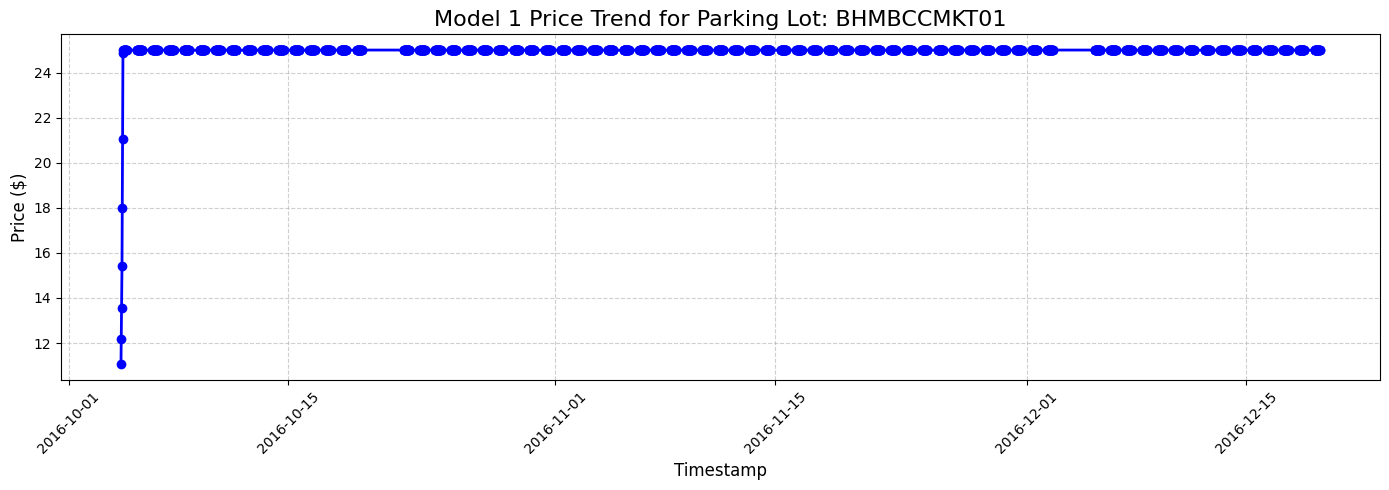

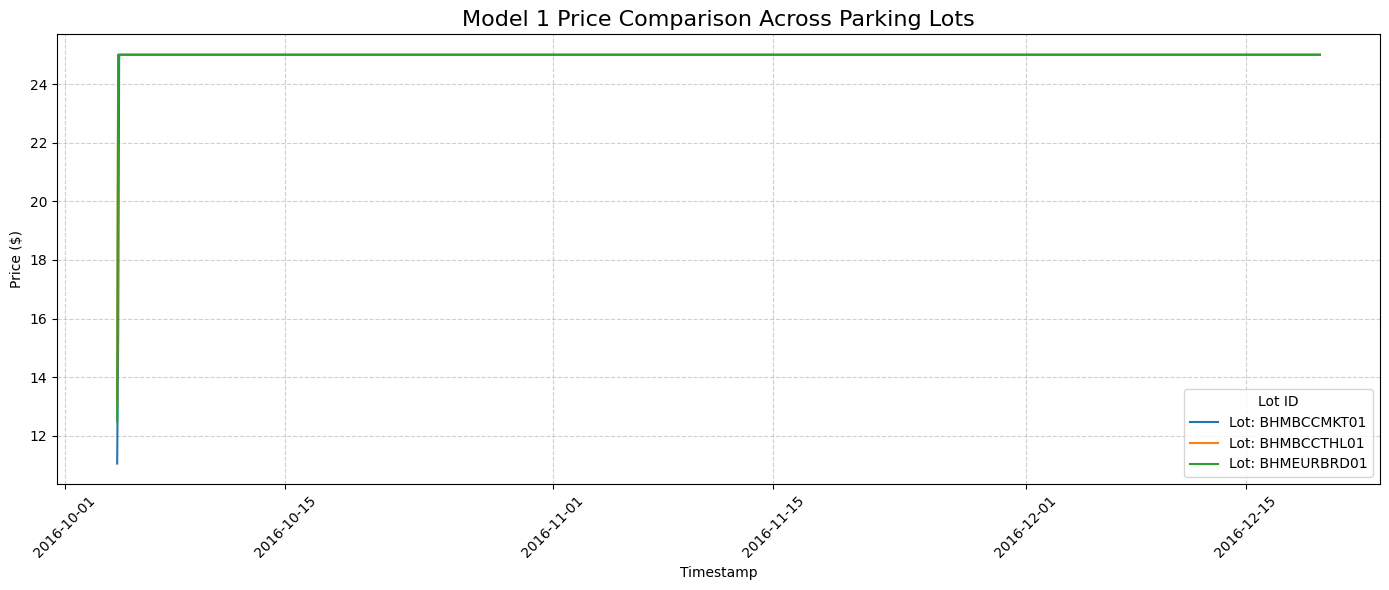

In [1]:
#Model 1: Baseline Linear Model

# ✅ STEP 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ STEP 2: Load the Dataset
csv_path = "/kaggle/input/final-project/dataset (1).csv"
df = pd.read_csv("/kaggle/input/final-project/dataset (1).csv")

# ✅ STEP 3: Preprocess Timestamps
df["Timestamp"] = pd.to_datetime(
    df["LastUpdatedDate"] + " " + df["LastUpdatedTime"],
    errors="coerce",     # Avoids crashing if format mismatch
    dayfirst=True        # Your format is DD-MM-YYYY
)


# ✅ STEP 4: Calculate Occupancy Rate
df["OccupancyRate"] = df["Occupancy"] / df["Capacity"]

# ✅ STEP 5: Apply Model 1 Pricing Logic
BASE_PRICE = 10.0
ALPHA = 10  # You can tune this value

# Initialize
df["Model1_Price"] = BASE_PRICE
current_prices = {lot: BASE_PRICE for lot in df["SystemCodeNumber"].unique()}

# Update prices over time for each lot
for lot_id in df["SystemCodeNumber"].unique():
    lot_data = df[df["SystemCodeNumber"] == lot_id]
    prev_price = BASE_PRICE
    for idx in lot_data.index:
        occ_rate = df.loc[idx, "OccupancyRate"]
        new_price = prev_price + ALPHA * occ_rate
        new_price = max(5, min(25, new_price))  # Bound the price
        df.at[idx, "Model1_Price"] = new_price
        prev_price = new_price

# ✅ STEP 6: Preview Result
df[["SystemCodeNumber", "Timestamp", "Occupancy", "Capacity", "OccupancyRate", "Model1_Price"]].head()
# ✅ Visualize for One Lot
lot_id = df["SystemCodeNumber"].unique()[0]  # Pick any ID you want
lot_data = df[df["SystemCodeNumber"] == lot_id].sort_values("Timestamp")

# Plot
plt.figure(figsize=(14, 5))
plt.plot(lot_data["Timestamp"], lot_data["Model1_Price"], marker='o', color='blue', linewidth=2)

# 📊 Presentation Tweaks
plt.title(f"Model 1 Price Trend for Parking Lot: {lot_id}", fontsize=16)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
# ✅ Visualize for First 3 Parking Lots
plt.figure(figsize=(14, 6))

for lot_id in df["SystemCodeNumber"].unique()[:3]:
    lot_data = df[df["SystemCodeNumber"] == lot_id].sort_values("Timestamp")
    plt.plot(lot_data["Timestamp"], lot_data["Model1_Price"], label=f"Lot: {lot_id}")

plt.title("Model 1 Price Comparison Across Parking Lots", fontsize=16)
plt.xlabel("Timestamp")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.legend(title="Lot ID")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


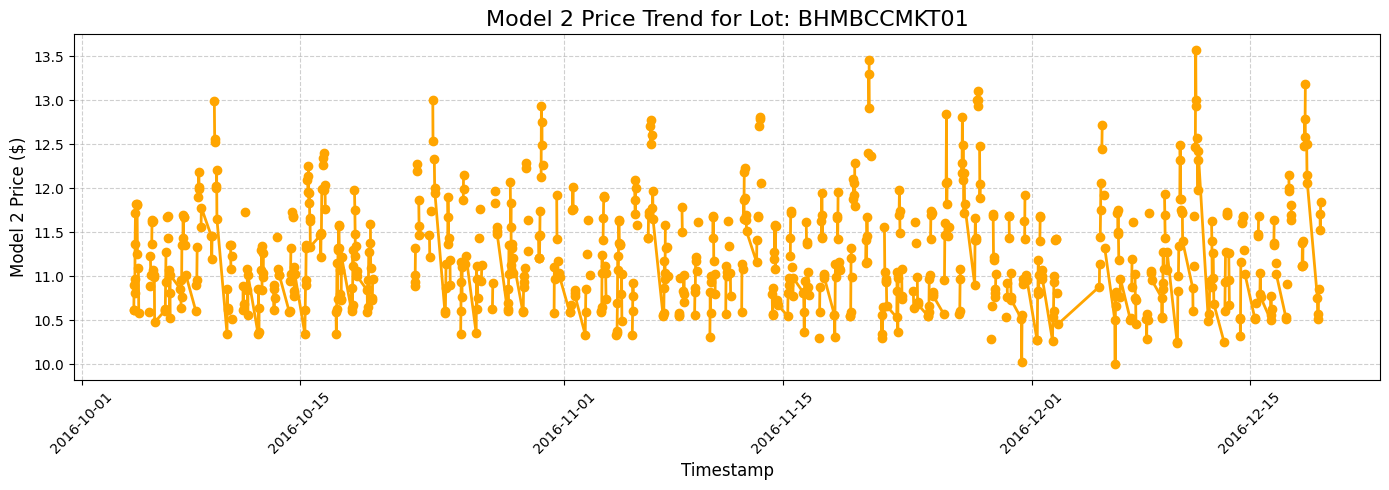

In [2]:
# -----------------------------
# ✅ Model 2: Demand-Based Pricing (Final Fixed Version)
# -----------------------------

# ✅ Step 1: Make sure Model 1 has run and 'result_df' is valid
try:
    result_df = result_df.copy()
except:
    result_df = df.copy()  # fallback to original data

# ✅ Step 2: Clean column names only if DataFrame is valid
if result_df is not None:
    result_df.columns = result_df.columns.str.strip()
else:
    raise ValueError("result_df is None — make sure Model 1 runs before Model 2")

# ✅ Step 3: Encode categorical features
def encode_features(df):
    required_cols = ['TrafficConditionNearby', 'VehicleType']
    for col in required_cols:
        if col not in df.columns:
            raise KeyError(f"❌ Missing required column: '{col}'")

    # Traffic mapping
    traffic_map = {'low': 0, 'medium': 1, 'high': 2}
    df['TrafficEncoded'] = df['TrafficConditionNearby'].map(traffic_map)

    # Vehicle type mapping
    vehicle_map = {'bike': 0.5, 'car': 1.0, 'truck': 1.5}
    df['VehicleWeight'] = df['VehicleType'].map(vehicle_map)

    return df

# ✅ Step 4: Compute Demand Score
def compute_demand_score(df, weights):
    α, β, γ, δ, ε = weights

    df['OccupancyRate'] = df['Occupancy'] / df['Capacity']

    df['DemandScore'] = (
        α * df['OccupancyRate'] +
        β * df['QueueLength'] -
        γ * df['TrafficEncoded'] +
        δ * df['IsSpecialDay'] +
        ε * df['VehicleWeight']
    )

    return df

# ✅ Step 5: Normalize demand to [0, 1]
def normalize_demand(df):
    min_d = df['DemandScore'].min()
    max_d = df['DemandScore'].max()

    if max_d == min_d:
        df['NormalizedDemand'] = 0
    else:
        df['NormalizedDemand'] = (df['DemandScore'] - min_d) / (max_d - min_d)

    return df

# ✅ Step 6: Apply final pricing formula
def apply_model2_price(df, base_price=10.0, λ=0.5):
    df['Model2_Price'] = base_price * (1 + λ * df['NormalizedDemand'])

    # Limit prices between $5 and $20
    df['Model2_Price'] = df['Model2_Price'].clip(lower=base_price * 0.5, upper=base_price * 2)

    return df

# ✅ Step 7: Run full Model 2 pipeline
weights = (1.0, 0.2, 0.3, 0.5, 0.4)  # (α, β, γ, δ, ε)

result_df = encode_features(result_df)
result_df = compute_demand_score(result_df, weights)
result_df = normalize_demand(result_df)
result_df = apply_model2_price(result_df)

# ✅ Step 8: Preview output
result_df[['SystemCodeNumber', 'Timestamp', 'OccupancyRate', 'QueueLength',
           'TrafficEncoded', 'IsSpecialDay', 'VehicleWeight',
           'DemandScore', 'NormalizedDemand', 'Model2_Price']].head()
import matplotlib.pyplot as plt

# ✅ Select one parking lot
lot_id = result_df['SystemCodeNumber'].unique()[0]  # You can change to a specific lot

# ✅ Filter data for that lot and sort by time
lot_data = result_df[result_df['SystemCodeNumber'] == lot_id].sort_values('Timestamp')

# ✅ Plot Model 2 pricing
plt.figure(figsize=(14, 5))
plt.plot(lot_data['Timestamp'], lot_data['Model2_Price'], marker='o', color='orange', linewidth=2)

# ✅ Enhancements
plt.title(f'Model 2 Price Trend for Lot: {lot_id}', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Model 2 Price ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipykernel_35/2250416231.py:18: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


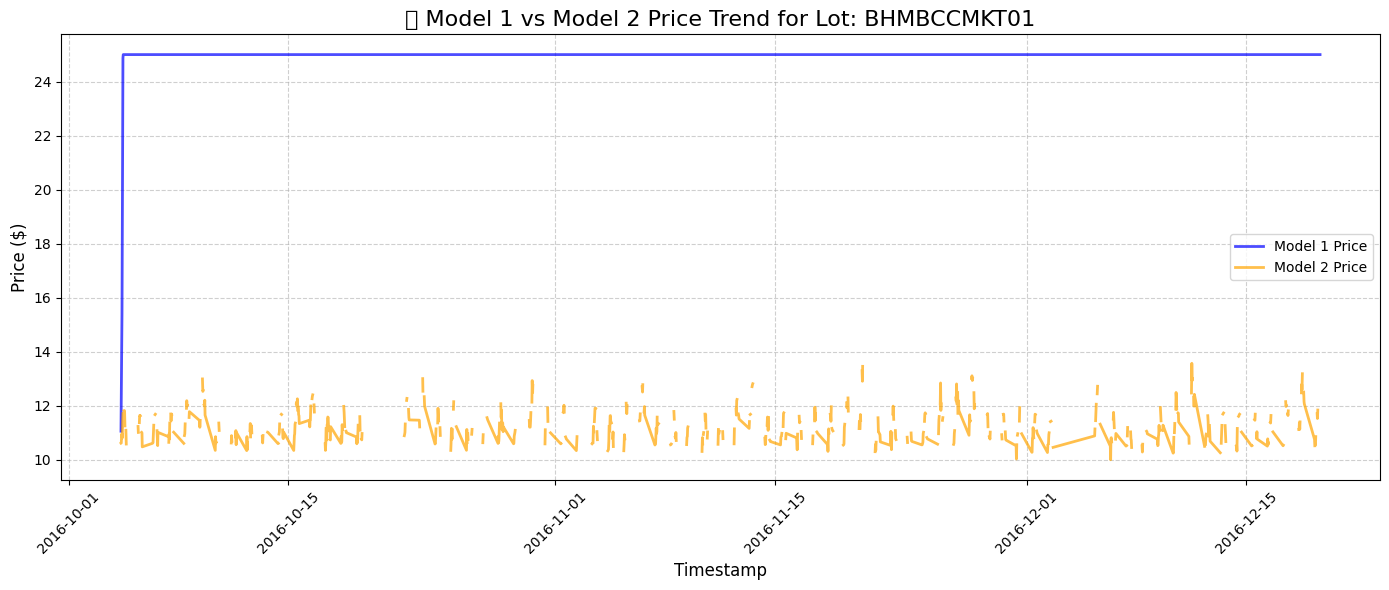

In [3]:
import matplotlib.pyplot as plt

# Filter data for one parking lot
lot_id = result_df['SystemCodeNumber'].unique()[0]  # Pick any one lot
lot_data = result_df[result_df['SystemCodeNumber'] == lot_id].sort_values("Timestamp")

# Plot both Model 1 and Model 2 prices
plt.figure(figsize=(14, 6))
plt.plot(lot_data['Timestamp'], lot_data['Model1_Price'], label='Model 1 Price', color='blue', linewidth=2, alpha=0.7)
plt.plot(lot_data['Timestamp'], lot_data['Model2_Price'], label='Model 2 Price', color='orange', linewidth=2, alpha=0.7)

plt.title(f'📈 Model 1 vs Model 2 Price Trend for Lot: {lot_id}', fontsize=16)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [4]:
from geopy.distance import geodesic

# ✅ Function to calculate distance (in km) between two lat/lon points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

# ✅ Function to apply competitive pricing
def apply_model3_price(df, radius_km=1.0, base_price=10.0, λ=0.4):
    df = df.copy()
    df['Model3_Price'] = df['Model2_Price']  # Start with Model2 as base

    lot_ids = df['SystemCodeNumber'].unique()

    for lot_id in lot_ids:
        lot_data = df[df['SystemCodeNumber'] == lot_id].sort_values("Timestamp")

        # Get lat/lon of current lot
        lat1 = lot_data['Latitude'].iloc[0]
        lon1 = lot_data['Longitude'].iloc[0]

        # Find nearby lots
        nearby_ids = []
        for other_id in lot_ids:
            if other_id == lot_id:
                continue
            other_data = df[df['SystemCodeNumber'] == other_id]
            lat2 = other_data['Latitude'].iloc[0]
            lon2 = other_data['Longitude'].iloc[0]
            distance = calculate_distance(lat1, lon1, lat2, lon2)
            if distance <= radius_km:
                nearby_ids.append(other_id)

        # Apply pricing logic per row
        updated_prices = []
        for idx, row in lot_data.iterrows():
            base_model2_price = row['Model2_Price']
            occupancy = row['Occupancy']
            capacity = row['Capacity']

            # Look at nearby lots at the same timestamp
            nearby_rows = df[
                (df['SystemCodeNumber'].isin(nearby_ids)) &
                (df['Timestamp'] == row['Timestamp'])
            ]

            if not nearby_rows.empty:
                avg_price = nearby_rows['Model2_Price'].mean()
                avg_occupancy = (nearby_rows['Occupancy'] / nearby_rows['Capacity']).mean()
            else:
                avg_price = base_model2_price
                avg_occupancy = occupancy / capacity if capacity > 0 else 0

            delta = (avg_price - base_model2_price) + (avg_occupancy - (occupancy / capacity))
            new_price = base_model2_price + λ * delta
            new_price = max(5, min(25, new_price))  # Bound the price

            updated_prices.append(new_price)

        df.loc[lot_data.index, 'Model3_Price'] = updated_prices

    return df
    # Apply Model 3
result_df = apply_model3_price(result_df)

# Preview
result_df[['SystemCodeNumber', 'Timestamp', 'Latitude', 'Longitude', 'Model1_Price', 'Model2_Price', 'Model3_Price']].head()



,SystemCodeNumber,Timestamp,Latitude,Longitude,Model1_Price,Model2_Price,Model3_Price
0,BHMBCCMKT01,2016-10-04 07:59:00,26.144536,91.736172,11.057192,10.612925,10.828429
1,BHMBCCMKT01,2016-10-04 08:25:00,26.144536,91.736172,12.166378,10.619473,10.924238
2,BHMBCCMKT01,2016-10-04 08:59:00,26.144536,91.736172,13.552860,10.906291,11.168801
3,BHMBCCMKT01,2016-10-04 09:32:00,26.144536,91.736172,15.407279,10.965226,11.277969
4,BHMBCCMKT01,2016-10-04 09:59:00,26.144536,91.736172,18.006932,10.807193,11.278070


/tmp/ipykernel_35/3789179051.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


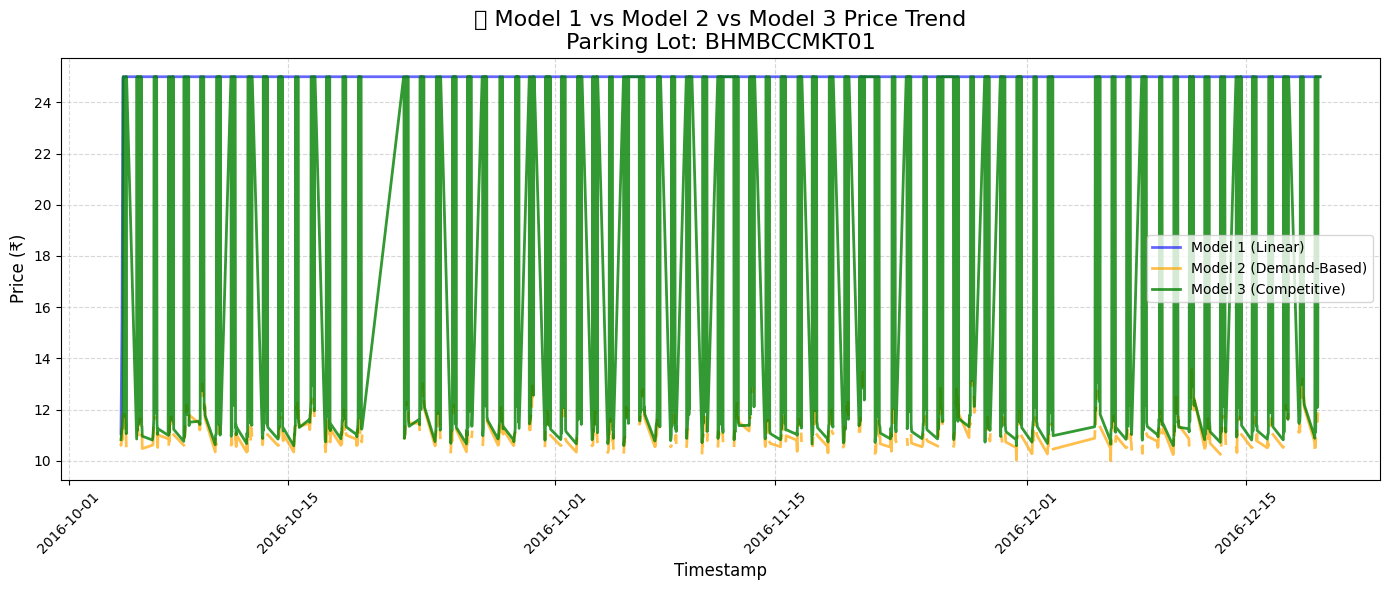

In [5]:
import matplotlib.pyplot as plt

# Choose one lot to visualize
lot_id = result_df['SystemCodeNumber'].unique()[0]
lot_data = result_df[result_df['SystemCodeNumber'] == lot_id].sort_values('Timestamp')

# Plot all three model prices
plt.figure(figsize=(14, 6))
plt.plot(lot_data['Timestamp'], lot_data['Model1_Price'], label="Model 1 (Linear)", color='blue', linewidth=2, alpha=0.6)
plt.plot(lot_data['Timestamp'], lot_data['Model2_Price'], label="Model 2 (Demand-Based)", color='orange', linewidth=2, alpha=0.7)
plt.plot(lot_data['Timestamp'], lot_data['Model3_Price'], label="Model 3 (Competitive)", color='green', linewidth=2, alpha=0.8)

# Presentation tweaks
plt.title(f"📈 Model 1 vs Model 2 vs Model 3 Price Trend\nParking Lot: {lot_id}", fontsize=16)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Price (₹)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
